
# Objective:
To prepare and enhance the dataset for accurate and efficient analysis, specifically for recommending personalized workout plans


1. Data Loading:

The notebook begins with loading exercise data from a CSV file, indicating the initial phase of data handling.

2. Data Cleaning:

This phase focuses on refining the dataset. It involves correcting typos, handling missing values, and ensuring data integrity, which is crucial for accurate analysis.

3. Handling Duplicate Data:

Special attention is given to identifying and addressing duplicate exercise names, vital for maintaining data quality.

4. Data Transformation and Feature Engineering:

The data is transformed to align with user inputs. This step includes mapping user preferences to corresponding categories in the exercise data, an essential aspect of feature engineering for accurate workout plan recommendations.

5. Data Merging and Validation:

User input data is merged with the exercise data, followed by validation checks like ensuring no duplicates or null values, crucial for the dataset's integrity.

6. User Input Processing:

A function is created for processing user inputs and dynamically querying exercises based on various preferences like experience level, muscle group, workout type, and equipment.

## Data Loading

In [1]:
import pandas as pd
import numpy as np
from glob import glob

The following data below was scraped from https://www.bodybuilding.com/exercises/finder, using the Python script in the repo.

In [2]:
exercise_data = pd.read_csv("../data/exercises_with_description.csv")
exercise_data.head()

,Name,Muscle,Equipment,Rating,Type,Level,Description
0,Rickshaw Carry,Forearms,Other,9.6,Strongman,Beginner,"1. Position the frame at the starting point, a..."
1,Single-Leg Press,Quadriceps,Machine,9.6,Strength,Intermediate,1. Load the sled to an appropriate weight. Sea...
2,Landmine twist,Abdominals,Other,9.5,Strength,Intermediate,1. Position a bar into a landmine or securely ...
3,Weighted pull-up,Lats,Other,9.5,Strength,Intermediate,1. Attach a weight to a dip belt and secure it...
4,T-Bar Row with Handle,Middle Back,Other,9.5,Strength,Intermediate,1. Position a bar into a landmine or in a corn...


In [3]:
exercise_data.shape

(1110, 7)

`Name` - Name of the exercise

`Muscle` - Target muscle group

`Equipment` - Required equipment

`Rating` - Rating/Optimality of the exercise

`Description` - Instructions on how to perform the exercise


## Data Cleaning



### Handle null values


In [4]:
# Check for null values
exercise_data.isna().sum()

Name            0
Muscle          0
Equipment      67
Rating         11
Type            2
Level           2
Description    13
dtype: int64

Remove exercises without a rating

In [5]:
exercise_data[exercise_data.Rating.isna()]

,Name,Muscle,Equipment,Rating,Type,Level,Description
1099,Dave Draper Forehead Curl,Biceps,Barbell,NaN,Strength,Intermediate,NaN
1100,Walking High Knee,Glutes,Body Only,NaN,Strength,Intermediate,NaN
1101,Walking Butt Kicks,Glutes,Body Only,NaN,Strength,Intermediate,NaN
1102,Walking Glute Stretch,Glutes,Body Only,NaN,Strength,Intermediate,NaN
1103,Side-To-Side Adductor Stretch,Adductors,Body Only,NaN,Strength,Intermediate,NaN
1104,Reverse Lunge Rotation,Quadriceps,Body Only,NaN,Strength,Intermediate,NaN
1105,Lunge kick,Glutes,Body Only,NaN,Strength,Intermediate,NaN
1106,Swiss Ball Ab Roll-Out,Abdominals,Exercise Ball,NaN,Strength,Intermediate,NaN
1107,Curtsy lunge,Glutes,Body Only,NaN,Strength,Intermediate,NaN
1108,Jump Lunge,Abdominals,Body Only,NaN,Strength,Intermediate,NaN


In [6]:
exercise_data_filtered = exercise_data.loc[~exercise_data.Rating.isnull(),]
exercise_data_filtered.shape

(1099, 7)

Fill in the missing exercise descriptions, based on similar exercises.

In [7]:
# Missing descriptions
exercise_data_filtered[exercise_data_filtered.Description.isna()]

,Name,Muscle,Equipment,Rating,Type,Level,Description
543,Pistol squat,Quadriceps,Body Only,7.9,NaN,NaN,NaN
576,Smith machine Bulgarian split squat,Quadriceps,Machine,7.7,NaN,NaN,NaN


In [8]:
# Similar exercises with fields present
exercise_data_filtered[exercise_data_filtered.Name.apply(lambda x: 'pistol squat' in x)]

,Name,Muscle,Equipment,Rating,Type,Level,Description
674,Smith machine pistol squat,Quadriceps,Machine,7.0,Strength,Intermediate,"1. To begin, first set the bar to a position t..."


In [9]:
exercise_data_filtered[exercise_data_filtered.Name.apply(lambda x: 'Bulgarian split squat' in x)]

,Name,Muscle,Equipment,Rating,Type,Level,Description
321,Barbell Bulgarian split squat,Quadriceps,Barbell,8.5,Strength,Intermediate,1. Start by standing about 2 to 3 feet in fron...
576,Smith machine Bulgarian split squat,Quadriceps,Machine,7.7,NaN,NaN,NaN


In [10]:
pistol_squat_description = """1. Squat down by flexing the knee and sitting back with the hips, outstretching your arms in front of you.
2. Hold the bottom position for a second and then reverse the motion, driving through the heel and keeping your head and chest up.
3. Lower yourself again and repeat."""

smith_machine_bulgarian_split_squat_description = """1. Start by standing and facing the bar of the smith machine. Have the smith machine bar at shoulder height. Set a flat bench about 2 to 3 feet behind you. Tip: Your feet should be shoulder width apart from each other.
2. While holding onto the bar with both hands using a pronated grip, lower your head and lean forward to rest the bar on the base of your neck. Your hands should be wider than shoulder width apart from each other.
3. Move one foot back so that your toe is resting on the flat bench. Your other foot should be stationary in front of you. Keep your head up at all times as looking down will get you off balance and also maintain a straight back. Tip: Make sure your back is straight and chest is out while performing this exercise.
4. As you inhale, slowly lower your leg until your thigh is parallel to the floor. At this point, your knee should be over your toes. Your chest should be directly above the middle of your thigh.
5. Leading with the chest and hips and contracting the quadriceps, elevate your leg back to the starting position as you exhale.
6. Repeat for the recommended amount of repetitions.
7. Switch legs and repeat the movement.


Caution:
 Keeping your balance with this exercise can be challenging. This is an advanced exercise and should not be performed unless you are an experienced weight lifter."""

pistol_squat_values = ['Strength', 'Beginner', pistol_squat_description]
smith_machine_bulgarian_split_squat_values = ['Strength', 'Intermediate', smith_machine_bulgarian_split_squat_description]

columns_to_fill = ['Type', 'Level', 'Description']
exercise_data_filtered.loc[exercise_data_filtered.Name == 'Pistol squat', columns_to_fill] = pistol_squat_values
exercise_data_filtered.loc[exercise_data_filtered.Name == 'Smith machine Bulgarian split squat', columns_to_fill] = smith_machine_bulgarian_split_squat_values

Fill in the missing equipment information

In [11]:
# Observe preexisting categories
exercise_data.Equipment.value_counts()

Equipment
Body Only        285
Barbell          186
Dumbbell         137
Other            131
Cable             75
Machine           68
Kettlebells       61
Bands             32
Medicine Ball     21
Exercise Ball     13
E-Z Curl Bar      11
Foam Roll          9
Cables             3
Dumbbells          3
Weight Bench       2
Body Weight        2
Mat                2
Cable Machine      1
Bosu Ball          1
Name: count, dtype: int64

In [12]:
# Fix 'Dumbbells' typo
exercise_data_filtered.loc[exercise_data_filtered['Equipment'] == 'Dumbbells', 'Equipment'] = 'Dumbbell'

# Fix 'Cables' and 'Cable Machine' typos
exercise_data_filtered.loc[exercise_data_filtered['Equipment'] == 'Cables', 'Equipment'] = 'Cable'
exercise_data_filtered.loc[exercise_data_filtered['Equipment'] == 'Cable Machine', 'Equipment'] = 'Cable'

In [13]:
missing_equipment = exercise_data_filtered[exercise_data_filtered.Equipment.isna()]
missing_equipment

,Name,Muscle,Equipment,Rating,Type,Level,Description
10,Straight-bar wrist roll-up,Forearms,NaN,9.5,Strength,Intermediate,1. Hold a barbell with both hands and your pal...
35,Reverse Band Box Squat,Quadriceps,NaN,9.3,Powerlifting,Intermediate,1. Begin in a power rack with a box at the app...
61,Hip Circles (Prone),Abductors,NaN,9.2,Stretching,Intermediate,1. Position yourself on your hands and knees o...
79,Zottman Curl,Biceps,NaN,9.1,Strength,Intermediate,1. Stand up with your torso upright and a dumb...
80,Glute ham raise-,Hamstrings,NaN,9.1,Strength,Beginner,1. You can use a partner for this exercise or ...
...,...,...,...,...,...,...,...
948,Glute Bridge Hamstring Walkout,Glutes,NaN,0.0,Strength,Intermediate,1. Begin in a supine position on the floor. Be...
996,Partner plank with high-five,Abdominals,NaN,0.0,Strength,Intermediate,1. Get into a plank position with your weight ...
1005,Split Squat With Kettlebells,Quadriceps,NaN,0.0,Strength,Intermediate,1. Position yourself into a staggered stance w...
1023,Hand Release Push-Up,Chest,NaN,0.0,Strength,Intermediate,1. Start on the floor with your hands slightly...


In [14]:
# Add equipment information
equipment_to_add = ['Barbell', 'Barbell', 'Body Only', 'Dumbbell', 'Body Only', 'Barbell', 'Dumbbell', 'Mat', 'Dumbbell', 'Body Only',
                    'Machine', 'Dumbbell', 'Kettlebells', 'Weight Bench', 'Bands', 'Body Only', 'Body Only', 'Dumbbell', 'Body Only', 'Kettlebells',
                    'Dumbbell', 'Body Only', 'Bands', 'Barbell', 'Machine', 'Body Only', 'Dumbbell', 'Dumbbell', 'Dumbbell', 'Body Only',
                    'Weight Bench', 'Body Only', 'Machine', 'Body Only', 'Body Only', 'Body Only', 'Body Only', 'Bands', 'Machine', 'Body Only',
                    'Body Only', 'Body Only', 'Body Only', 'Body Only', 'Mat', 'Body Only', 'Body Only', 'Body Only', 'Body Only', 'Body Only',
                    'Body Only', 'Body Only', 'Body Only', 'Body Only', 'Body Only', 'Body Only', 'Body Only', 'Body Only', 'Body Only', 'Body Only',
                    'Dumbbell', 'Kettlebells', 'Body Only', 'Body Weight', 'Kettlebells', 'Body Only', 'Machine']

assert len(equipment_to_add) == len(missing_equipment)

# Insert missing equipment information
exercise_data_filtered.loc[exercise_data_filtered.Equipment.isna(), 'Equipment'] = equipment_to_add

In [15]:
exercise_data_filtered.isna().sum()

Name           0
Muscle         0
Equipment      0
Rating         0
Type           0
Level          0
Description    0
dtype: int64

All null values have been resolved.


### Handle duplicate exercise names


In [16]:
# Check for unique exercise names
exercise_data_filtered.loc[:,'Name'] = exercise_data_filtered.Name.apply(lambda x: x.strip())
print(f'Is unique: {exercise_data_filtered.Name.is_unique}')

duplicated_exercises = exercise_data_filtered[exercise_data_filtered.duplicated(subset = 'Name', keep = False)]
print(f"# Duplicates: {len(duplicated_exercises)}")
duplicated_exercises.sort_values('Name').head(6)

Is unique: False
# Duplicates: 30


,Name,Muscle,Equipment,Rating,Type,Level,Description
612,Balance Board,Calves,Other,7.5,Strength,Beginner,Note:\n This exercise is designed to increase ...
597,Balance Board,Calves,Other,7.5,Strength,Beginner,Note:\n This exercise is designed to increase ...
588,Band-assisted pull-up,Lats,Bands,7.6,Strength,Intermediate,1. Choke the band around the center of the pul...
603,Band-assisted pull-up,Lats,Bands,7.6,Strength,Intermediate,1. Choke the band around the center of the pul...
589,Barbell Bench Press-Wide Grip,Chest,Barbell,7.6,Strength,Beginner,1. Load the bar to an appropriate weight for y...
604,Barbell Bench Press-Wide Grip,Chest,Barbell,7.6,Strength,Beginner,1. Load the bar to an appropriate weight for y...


In [17]:
# Identify and handle duplicates
duplicates_mask = exercise_data_filtered.duplicated(subset = 'Name', keep = False)

# For each pair of duplicates, assert that 'Muscle', 'Equipment', and 'Rating' values are the same
duplicates_to_handle = exercise_data_filtered[duplicates_mask]
for _, group in duplicates_to_handle.groupby('Name'):
    # Check conditions for each group of duplicates
    assert group['Muscle'].nunique() == 1
    assert group['Equipment'].nunique() == 1
    assert group['Rating'].nunique() == 1
    assert group['Type'].nunique() == 1
    assert group['Level'].nunique() == 1

print("All duplicate exercises have the same column values")

# Keep the first occurrence of duplicates
exercise_data_dedup = exercise_data_filtered.drop_duplicates(subset = 'Name', keep = 'first')

All duplicate exercises have the same column values


In [18]:
print(f'Is unique: {exercise_data_dedup.Name.is_unique}')

Is unique: True


In [19]:
exercise_data_dedup.shape

(1084, 7)

In [20]:
# exercise_data_dedup.to_csv("../data/exercises_data_cleaned.csv", index = False)


## Feature Engineering



### Refine Features


Examine 'Other' equipment category

In [21]:
exercise_data_dedup[exercise_data_dedup.Equipment == 'Other'].head()

,Name,Muscle,Equipment,Rating,Type,Level,Description
0,Rickshaw Carry,Forearms,Other,9.6,Strongman,Beginner,"1. Position the frame at the starting point, a..."
2,Landmine twist,Abdominals,Other,9.5,Strength,Intermediate,1. Position a bar into a landmine or securely ...
3,Weighted pull-up,Lats,Other,9.5,Strength,Intermediate,1. Attach a weight to a dip belt and secure it...
4,T-Bar Row with Handle,Middle Back,Other,9.5,Strength,Intermediate,1. Position a bar into a landmine or in a corn...
6,Atlas Stones,Lower Back,Other,9.5,Strongman,Intermediate,1. Begin with the atlas stone between your fee...


In [22]:
sum(exercise_data_dedup.Equipment == 'Other')

129

In [23]:
# Create dictionary to correctly classify 'Other' equipment
equipment_dict = {"Dumbbell farmer's walk": 'Dumbbell',
                  'Lying Face Up Plate Neck Resistance': 'Plate',
                  'Chest dip': 'Machine',
                  'Rocky Pull-Ups/Pulldowns': 'Machine',
                  'Car driver': 'Plate',
                  'Plate Twist': 'Plate',
                  'Front Plate Raise': 'Plate',
                  "Captain's chair knee raise": 'Machine',
                  'Standing Olympic Plate Hand Squeeze': 'Plate',
                  'Gironda Sternum Chins': 'Machine',
                  'Pallof press': 'Cable',
                  'Lying Face Up Plate Neck Resistance': 'Plate',
                  'Weighted sissy squat': 'Plate',
                  'Plate Pinch': 'Plate',
                  'Smith machine inverted row': 'Machine',
                  'Weighted Sit-Ups - With Bands': 'Bands',
                  'Lying T-Bar Row': 'Machine',
                  'Reverse Plate Curls': 'Plate',
                  'Barbell squat with plate slide': 'Barbell',
                  'One Arm Chin-Up': 'Machine',
                  'Crucifix': 'Dumbbell',
                  'Burpee over barbell': 'Barbell',
                  'Weighted Push-Up': 'Plate',
                  'Plate walking lunge': 'Dumbbell',
                  'Plate shoulder circle big to small': 'Plate',
                  'Plate hammer curl': 'Plate',
                  'Svend press': 'Plate',
                  "Waiter's carry": 'Plate',
                  'Single-leg knee-tap squat': 'Bosu Ball',
                  'Bar Push-Up Smith Machine': 'Machine'}

exercise_data_dedup.set_index('Name', inplace = True)
exercise_data_dedup.update(pd.Series(equipment_dict, name = 'Equipment'))
exercise_data_dedup.reset_index(inplace = True)

In [24]:
exercise_data_dedup.Equipment.value_counts()

Equipment
Body Only        306
Barbell          188
Dumbbell         151
Other            101
Machine           81
Cable             80
Kettlebells       64
Bands             34
Medicine Ball     21
Plate             13
Exercise Ball     12
E-Z Curl Bar      11
Foam Roll          9
Mat                4
Weight Bench       4
Body Weight        3
Bosu Ball          2
Name: count, dtype: int64


### Add features


In [25]:
exercise_data_dedup.Level.value_counts()

Level
Intermediate    615
Beginner        461
Expert            8
Name: count, dtype: int64

We need a column indicating the difficulty of each exercise, matching user preferences. The website bodybuilding.com does not have well defined categories for the difficulties of the exercises. Only 8 exercises are listed as "Expert".



I will attach the cleaned dataset above for ChatGPT-4 to categorize the difficulty and type of each exercise, given the description. This will reduce human bias while maintaining accuracy. The prompt is shown below.

Initial Prompt:

1) Load the CSV and only analyze the first set of 25 exercises, using df.head(25). Ignore the "Rating", "Type" and "Level" columns.
2) Without Python, manually assign a difficulty level ("Beginner," "Intermediate," or "Advanced") to each exercise in the dataframe, based on its complexity and intensity using the "Description" column. The constraints for each difficulty level are detailed below delimited by triple quotes.
3) For the set of exercises, you should manually output the level category, a summary of the exercise and the reasoning for the level classification.
4) Include exercises that are only from the current set. Ensure all 25 exercises are properly classified.
5) Then, you will output a CSV that I can download with four fields: 'Name' of each exercise, 'Difficulty' as outputted above, 'Summary' of the exercise as outputted above, and 'Reasoning' as outputted above.
6) Finally, ask if I want to proceed to load, categorize and create a CSV for the next set of 25 exercises. Repeat this until all exercises in the CSV have been assigned a difficulty.
7) At the end, the final output should be a CSV file of all the CSV files concatenated sequentially.


"""

Beginner:

1) Common Exercises: Basic or classic exercises that are widely practiced in general fitness routines. This can encompass both traditional and slightly more innovative exercises.
2) Simple to Slightly Complex Movement Patterns: Exercises with straightforward movements and those that introduce a bit more complexity, provided they don't demand advanced skills or coordination. Permit exercises that may require compound movements.
3) Machine-Based and Simple Free Weight Exercises: Machine-based, free weight or bodyweight exercises that are common and relatively easy to perform, like basic dumbbell and barbell movements.
4) Moderate Intensity and Weight Range: Exercises that can be performed at a moderate level of intensity. This would cover exercises that are doable in a higher repetition range with manageable weights, accommodating a wider skill range.
5) Basic to Moderate Balance and Strength: Exercises requiring a level of balance and coordination that is achievable for someone at the entry-level of fitness or a regular gym-goer.
6) Low to Moderate Injury Risk with Proper Form: Exercises that are generally safe with proper form and technique. The emphasis should be on exercises where proper form is achievable without extensive prior training.
7) Learning Curve with Some Challenge: Exercises that can be learned with some practice and are not overly intimidating for beginners. This might include exercises that require a bit more attention initially but can be quickly mastered.
8) Non-Explosive to Gently Dynamic Movements: Exercises that involve more dynamic movements but aren't extremely explosive or high-impact.


Intermediate:

1) Diverse Range of Exercises: Exercises that are less common but not necessarily rare or specialized. This opens up the category to a wider variety of movements that are seen in general fitness routines but aren't the first choices for beginners.
2) Moderate to High Complexity: Exercises with a higher degree of difficulty than those categorized as beginner, and that might involve more complex movement patterns or combinations of movements.
3) Substantial Technical Skill: Exercises that require a significant level of technical understanding and practice, but not to the extent of specialized athletic or advanced training routines.
4) Moderate to High Intensity: Exercises that are performed with moderate to heavy weights. This allows for more challenging strength training exercises that require good form and controlled execution.


Advanced:

1) Specialized Equipment: Exercises that require complex or unconventional gym equipment. These equipment are usually not found at a casual gym.
2) High Complexity and Skill Requirement: Exercises that demand advanced technical skills, coordination, and balance.
3) High Intensity and Strength Demand: Exercises that are typically performed with high weight or intensity.
4) Specific to Sports or Advanced Training: Including exercises commonly performed by athletes in sports like powerlifting, Olympic weightlifting, or bodybuilding.
5) Explosive and Dynamic Movements: Exercises that require quick, powerful movements.

"""

The ChatGPT-4 conversation is provided [here](https://chat.openai.com/share/417406ea-9edb-4647-a0c1-4c7dffc1531d)

In [26]:
def concatenate_classification_data(pattern):
    
    # Define the file pattern
    file_pattern = pattern
    
    # Get a list of file paths matching the pattern, sorting in numerical order
    file_paths = sorted(glob(file_pattern), key = lambda x: int(x.split('set')[1].split('_')[0]))
    
    # Initialize an empty list to store DataFrames
    dfs = []
    
    # Iterate through the file paths and load each CSV into a DataFrame
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        dfs.append(df)

    return pd.concat(dfs, ignore_index = True)


# Concatenate the list of DataFrames into a single DataFrame
exercises_with_level = concatenate_classification_data("../data/chatgpt/set*_exercises_difficulty_classification.csv")
exercises_with_level.head()

,Name,Difficulty,Summary,Reasoning
0,Rickshaw Carry,Intermediate,Carrying a loaded frame for distance.,"Requires moderate balance and strength, and a ..."
1,Single-Leg Press,Beginner,Leg press exercise performed with one leg.,"Machine-based and simple movement, suitable fo..."
2,Landmine twist,Intermediate,Twisting motion using a barbell fixed at one end.,Involves moderate complexity and requires good...
3,Weighted pull-up,Advanced,Pull-ups performed with additional weight.,"High intensity and strength demand, suitable f..."
4,T-Bar Row with Handle,Intermediate,Rowing movement with a barbell fixed at one end.,Requires substantial technical skill and moder...


In [27]:
# exercises_with_level.to_csv("../data/exercises_difficulty_classification.csv", index = False)

In [28]:
# Merge with classification data with exercise data
assert list(exercise_data_dedup.Name) == list(exercises_with_level.Name)

exercises_data_full = pd.merge(exercise_data_dedup, exercises_with_level, on = 'Name')
exercises_data_full.head(2)

,Name,Muscle,Equipment,Rating,Type,Level,Description,Difficulty,Summary,Reasoning
0,Rickshaw Carry,Forearms,Other,9.6,Strongman,Beginner,"1. Position the frame at the starting point, a...",Intermediate,Carrying a loaded frame for distance.,"Requires moderate balance and strength, and a ..."
1,Single-Leg Press,Quadriceps,Machine,9.6,Strength,Intermediate,1. Load the sled to an appropriate weight. Sea...,Beginner,Leg press exercise performed with one leg.,"Machine-based and simple movement, suitable fo..."


Compare 'Level' and 'Difficulty' assignments

In [29]:
print(f"# matching: {sum(exercises_data_full.Level == exercises_data_full.Difficulty)}")

# matching: 453


In [30]:
exercises_data_full.Level.value_counts()

Level
Intermediate    615
Beginner        461
Expert            8
Name: count, dtype: int64

In [31]:
exercises_data_full.Difficulty.value_counts()

Difficulty
Intermediate    620
Advanced        260
Beginner        204
Name: count, dtype: int64

ChatGPT does a better job at classifying 'Advanced' exercises. This is due to having broader constraints, like specialized equipment and explosive movements. However, it did not consider many exercises as 'Beginner'. I want beginners to also be exposed to exercises of moderate difficulty. Therefore, we will utilize the 'Level' column to determine beginner exercises that were misclassified in the 'Difficulty' column.

In [32]:
def calculate_overall_difficulty(row):
    if row['Level'] == 'Beginner' and row['Difficulty'] == 'Intermediate':
        return 'Beginner'
    else:
        return row['Difficulty']

# Apply the custom function to create the new column
exercises_data_full['Overall_Difficulty'] = exercises_data_full.apply(calculate_overall_difficulty, axis = 1)
exercises_data_full.head(3)

,Name,Muscle,Equipment,Rating,Type,Level,Description,Difficulty,Summary,Reasoning,Overall_Difficulty
0,Rickshaw Carry,Forearms,Other,9.6,Strongman,Beginner,"1. Position the frame at the starting point, a...",Intermediate,Carrying a loaded frame for distance.,"Requires moderate balance and strength, and a ...",Beginner
1,Single-Leg Press,Quadriceps,Machine,9.6,Strength,Intermediate,1. Load the sled to an appropriate weight. Sea...,Beginner,Leg press exercise performed with one leg.,"Machine-based and simple movement, suitable fo...",Beginner
2,Landmine twist,Abdominals,Other,9.5,Strength,Intermediate,1. Position a bar into a landmine or securely ...,Intermediate,Twisting motion using a barbell fixed at one end.,Involves moderate complexity and requires good...,Intermediate


In [33]:
exercises_data_full.Overall_Difficulty.value_counts()

Overall_Difficulty
Beginner        442
Intermediate    382
Advanced        260
Name: count, dtype: int64

Add categorized rating feature

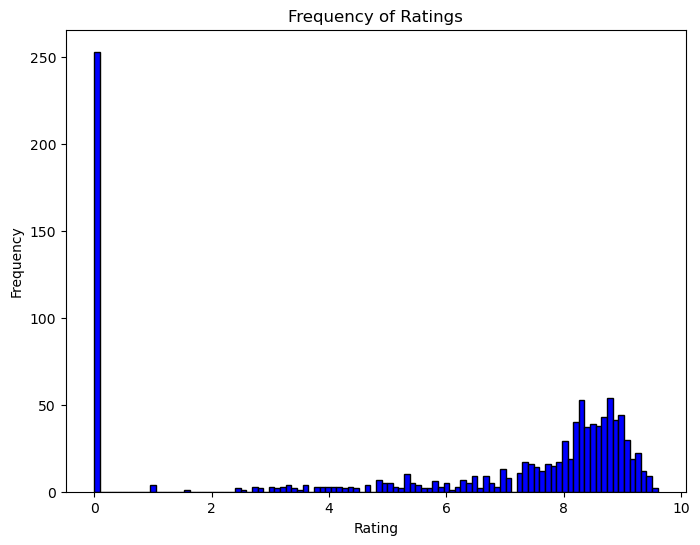

In [34]:
import matplotlib.pyplot as plt

ratings = exercises_data_full['Rating']
# Plotting
plt.figure(figsize=(8, 6))

# Plot Log Transformation
plt.hist(ratings, bins = 100, color = 'blue', edgecolor = 'black')
plt.title('Frequency of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.show()

Any rating that is less than 1 is rounded down to zero.

In [35]:
# Function to categorize 'Rating' into 'Optimality'
def categorize_rating(x):
    if 0.0 <= x < 2.0:
        return 'Poor'
    elif 2.0 <= x < 6.0:
        return 'Fair'
    elif 6.0 <= x < 8.0:
        return 'Good'
    elif 8.0 <= x < 10.0:
        return 'Excellent'

# Apply the function to create the 'Optimality' column
exercises_data_full['Optimality'] = exercises_data_full['Rating'].apply(categorize_rating)

exercises_data_full.head(3)

,Name,Muscle,Equipment,Rating,Type,Level,Description,Difficulty,Summary,Reasoning,Overall_Difficulty,Optimality
0,Rickshaw Carry,Forearms,Other,9.6,Strongman,Beginner,"1. Position the frame at the starting point, a...",Intermediate,Carrying a loaded frame for distance.,"Requires moderate balance and strength, and a ...",Beginner,Excellent
1,Single-Leg Press,Quadriceps,Machine,9.6,Strength,Intermediate,1. Load the sled to an appropriate weight. Sea...,Beginner,Leg press exercise performed with one leg.,"Machine-based and simple movement, suitable fo...",Beginner,Excellent
2,Landmine twist,Abdominals,Other,9.5,Strength,Intermediate,1. Position a bar into a landmine or securely ...,Intermediate,Twisting motion using a barbell fixed at one end.,Involves moderate complexity and requires good...,Intermediate,Excellent


In [36]:
exercises_data_full['Optimality'].value_counts()

Optimality
Excellent    531
Poor         258
Good         188
Fair         107
Name: count, dtype: int64

In [37]:
# Keep track of exercise index after merging with user data downstream
exercises_data_full = exercises_data_full.reset_index()
exercises_data_full.head()

,index,Name,Muscle,Equipment,Rating,Type,Level,Description,Difficulty,Summary,Reasoning,Overall_Difficulty,Optimality
0,0,Rickshaw Carry,Forearms,Other,9.6,Strongman,Beginner,"1. Position the frame at the starting point, a...",Intermediate,Carrying a loaded frame for distance.,"Requires moderate balance and strength, and a ...",Beginner,Excellent
1,1,Single-Leg Press,Quadriceps,Machine,9.6,Strength,Intermediate,1. Load the sled to an appropriate weight. Sea...,Beginner,Leg press exercise performed with one leg.,"Machine-based and simple movement, suitable fo...",Beginner,Excellent
2,2,Landmine twist,Abdominals,Other,9.5,Strength,Intermediate,1. Position a bar into a landmine or securely ...,Intermediate,Twisting motion using a barbell fixed at one end.,Involves moderate complexity and requires good...,Intermediate,Excellent
3,3,Weighted pull-up,Lats,Other,9.5,Strength,Intermediate,1. Attach a weight to a dip belt and secure it...,Advanced,Pull-ups performed with additional weight.,"High intensity and strength demand, suitable f...",Advanced,Excellent
4,4,T-Bar Row with Handle,Middle Back,Other,9.5,Strength,Intermediate,1. Position a bar into a landmine or in a corn...,Intermediate,Rowing movement with a barbell fixed at one end.,Requires substantial technical skill and moder...,Intermediate,Excellent



### Fix duplicates


Some exercises do not have the same name due to case sensitivity and a '-' suffix

In [38]:
exercises_data_full.loc[:,'Name_cleaned'] = exercises_data_full.loc[:,'Name'].apply(lambda x: x.rstrip('-').lower())
index_duplicated = exercises_data_full.duplicated(subset = 'Name_cleaned', keep = False)
exercises_data_full[index_duplicated].sort_values('Name_cleaned')

,index,Name,Muscle,Equipment,Rating,Type,Level,Description,Difficulty,Summary,Reasoning,Overall_Difficulty,Optimality,Name_cleaned
624,624,Dumbbell Walking Lunge,Quadriceps,Dumbbell,7.3,Strength,Intermediate,1. Begin standing with your feet about hip-wid...,Intermediate,Leg exercise involving lunges while walking.,"Improves leg strength and endurance, walking l...",Intermediate,Good,dumbbell walking lunge
842,842,Dumbbell walking lunge-,Quadriceps,Other,0.0,Strength,Intermediate,1. Select a plate that youâ€™re able to hold o...,Intermediate,"Lower body exercise with dumbbells, focusing o...","Strengthens legs, walking lunge adds mobility ...",Intermediate,Poor,dumbbell walking lunge
99,99,EZ-Bar Skullcrusher,Triceps,E-Z Curl Bar,9.0,Strength,Intermediate,"1. Using a close grip, lift the EZ bar and hol...",Intermediate,Triceps exercise performed with an EZ-bar.,Requires triceps strength and control.,Intermediate,Excellent,ez-bar skullcrusher
496,496,EZ-bar skullcrusher-,Triceps,E-Z Curl Bar,8.1,Strength,Intermediate,1. Lie on a flat bench with either an e-z bar ...,Beginner,Triceps extension exercise using an EZ-bar.,"Targets triceps, EZ-bar provides comfortable g...",Beginner,Excellent,ez-bar skullcrusher
80,80,Glute ham raise-,Hamstrings,Body Only,9.1,Strength,Beginner,1. You can use a partner for this exercise or ...,Intermediate,Exercise targeting the glutes and hamstrings.,Requires strength and control in the posterior...,Beginner,Excellent,glute ham raise
356,356,Glute Ham Raise,Hamstrings,Machine,8.4,Powerlifting,Intermediate,1. Begin by adjusting the equipment to fit you...,Intermediate,Lower body exercise focusing on the glutes and...,"Challenges the posterior chain, requires good ...",Intermediate,Excellent,glute ham raise
345,345,Jumping jack-,Quadriceps,Body Only,8.5,Plyometrics,Intermediate,1. Start by standing with your feet together. ...,Beginner,Cardiovascular exercise involving jumping with...,"Simple cardio exercise, suitable for all fitne...",Beginner,Excellent,jumping jack
1037,1037,Jumping Jack,Quadriceps,Body Only,0.0,Cardio,Intermediate,"1. Begin by standing with your feet together, ...",Beginner,Cardio exercise involving jumping and arm move...,"Improves cardiovascular fitness, jumping jack ...",Beginner,Poor,jumping jack
31,31,Power snatch-,Quadriceps,Barbell,9.3,Olympic Weightlifting,Expert,1. Place your feet at a shoulder width stance ...,Advanced,"Olympic lifting movement, lifting barbell from...","High technical skill, coordination, and explos...",Advanced,Excellent,power snatch
54,54,Power Snatch,Hamstrings,Barbell,9.2,Olympic Weightlifting,Beginner,1. Begin with a loaded barbell on the floor. T...,Advanced,"Olympic lifting movement, lifting barbell from...","High technical skill, coordination, and explos...",Advanced,Excellent,power snatch


We can keep the duplicates for glute ham raise, jumping jacks, power snatch, and sled push because they build multiple muscle groups and/or classified as multiple exercise types. They are also categorized into the same difficulty.

In [39]:
# Rename 'Dumbbell walking lunge-'
exercises_data_full.loc[exercises_data_full.Name == 'Dumbbell walking lunge-', 'Name'] = 'Plate Walking Lunge'

# Replace 'EZ-Bar Skullcrusher' description with 'EZ-Bar skullcrusher-' description, then delete 'EZ-bar skullcrusher-'
index1 = exercises_data_full[exercises_data_full.Name == 'EZ-Bar Skullcrusher'].index[0]
index2 = exercises_data_full[exercises_data_full.Name == 'EZ-bar skullcrusher-'].index[0]
exercises_data_full.loc[index1, 'Description'] = exercises_data_full.loc[index2, 'Description']
exercises_data_full.drop(exercises_data_full[exercises_data_full['Name'] == 'EZ-bar skullcrusher-'].index, inplace = True)

# CLeaned names no longer needed
del exercises_data_full['Name_cleaned']

In [40]:
# exercises_data_full.to_csv("../app/data/exercises_difficulty_classification_full.csv", index = False)


### Map and Aggregate Features


Create a unified dataset by mapping the user data to the exercise data

In [41]:
# Mapping for 'Level' (Fitness_Experience)
difficulty_mapping = {
    'Beginner': 'Beginner',
    'Intermediate': 'Intermediate',
    'Advanced': 'Advanced'
}

# Mapping for 'Type' (Workout_Type)
type_mapping = {
    'Cardio': 'Cardio',
    'Olympic Weightlifting': 'Olympic Weightlifting',
    'Plyometrics': 'Plyometrics',
    'Powerlifting': 'Powerlifting',
    'Strength': 'Strength',
    'Stretching': 'Stretching',
    'Strongman': 'Strongman'
}

# Mapping for 'Muscle' (Desired_Muscle_Groups)
muscle_mapping = {
    'Chest': 'Chest',
    'Back': ['Lats', 'Middle Back', 'Lower Back', 'Traps'],
    'Shoulders': 'Shoulders',
    'Arms': ['Forearms', 'Biceps', 'Triceps'],
    'Legs': ['Adductors', 'Hamstrings', 'Quadriceps', 'Calves'],
    'Core': 'Abdominals',
    'Glutes': ['Glutes', 'Abductors'],
    'Neck': 'Neck',
    'Full Body': ['Lats', 'Middle Back', 'Lower Back', 'Traps', 'Chest', 'Shoulders', 'Forearms', 'Biceps', 'Triceps', 'Adductors', 'Hamstrings', 'Quadriceps', 'Calves', 'Abdominals', 'Glutes', 'Abductors', 'Neck']
}

# Mapping for 'Equipment'
equipment_mapping = {
    'At Home (Body)': ['Body Only', 'Body Weight'],
    'At Home (Equipment)': ['Bands', 'Medicine Ball', 'Exercise Ball', 'Foam Roll', 'Mat', 'Bosu Ball'],
    'Gym (Machine)': ['Machine', 'Cable'],
    'Gym (Equipment)': ['Barbell', 'Dumbbell', 'Kettlebells', 'Weight Bench', 'E-Z Curl Bar', 'Plates'],
    'No Preference': ['Body Only', 'Bands', 'Medicine Ball', 'Exercise Ball', 'Foam Roll', 'Mat', 'Bosu Ball', 'Machine',
                      'Cable', 'Barbell', 'Dumbbell', 'Kettlebells', 'Weight Bench', 'E-Z Curl Bar', 'Plate', 'Other']
}

# Apply mappings to user data
user_input_data = pd.read_csv("../data/mock_user_inputs.csv")
user_input_data['Overall_Difficulty'] = user_input_data['Fitness_Experience'].map(difficulty_mapping)
user_input_data['Type'] = user_input_data['Workout_Type'].map(type_mapping)
user_input_data['Muscle'] = user_input_data['Desired_Muscle_Groups'].apply(lambda x: [muscle_mapping[m] for m in x.split(', ')])
user_input_data['Equipment'] = user_input_data['Available_Equipment'].apply(lambda x: [equipment_mapping[e] for e in x.split(', ')])

# Flatten the 'Muscle' and 'Equipment' columns
user_input_data_flat = user_input_data.explode('Muscle').explode('Muscle').explode('Equipment').explode('Equipment')

# Perform a merge on common columns ('Muscle', 'Equipment', 'Type', 'Level')
merged_data = pd.merge(user_input_data_flat, exercises_data_full, on = ['Muscle', 'Equipment', 'Type', 'Overall_Difficulty'])

# Display the resulting dataset
merged_data.loc[:, 'Description' != merged_data.columns]


,User_ID,Fitness_Experience,Desired_Muscle_Groups,Workout_Frequency,Workout_Type,Available_Equipment,Overall_Difficulty,Type,Muscle,Equipment,index,Name,Rating,Level,Difficulty,Summary,Reasoning,Optimality
0,3,Intermediate,Full Body,1-2 days/week,Strength,Gym (Machine),Intermediate,Strength,Lats,Machine,228,V-bar pull-up,8.8,Intermediate,Intermediate,Pull-up variation using a V-bar.,"Targets the back and biceps, requires grip str...",Excellent
1,3,Intermediate,Full Body,1-2 days/week,Strength,Gym (Machine),Intermediate,Strength,Lats,Machine,322,Reverse-grip lat pull-down,8.5,Intermediate,Intermediate,Back exercise involving a lat pull-down with a...,Targets the lats with a focus on the lower por...,Excellent
2,3,Intermediate,Full Body,1-2 days/week,Strength,Gym (Machine),Intermediate,Strength,Lats,Machine,622,Single-arm pull-down,7.3,Intermediate,Intermediate,Lat pull-down performed with one arm.,"Strengthens lats, single-arm pull-down isolate...",Good
3,9,Intermediate,"Back, Neck, Shoulders",7 days/week,Strength,No Preference,Intermediate,Strength,Lats,Machine,228,V-bar pull-up,8.8,Intermediate,Intermediate,Pull-up variation using a V-bar.,"Targets the back and biceps, requires grip str...",Excellent
4,9,Intermediate,"Back, Neck, Shoulders",7 days/week,Strength,No Preference,Intermediate,Strength,Lats,Machine,322,Reverse-grip lat pull-down,8.5,Intermediate,Intermediate,Back exercise involving a lat pull-down with a...,Targets the lats with a focus on the lower por...,Excellent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307493,95263,Advanced,"Back, Glutes",5-6 days/week,Strength,No Preference,Advanced,Strength,Lower Back,Other,1021,Partner bench back extension,0.0,Beginner,Advanced,Partner exercise focusing on back extension on...,"Strengthens back, partner back extension adds ...",Poor
1307494,98145,Advanced,"Arms, Back, Chest, Glutes, Shoulders",3-4 days/week,Strength,No Preference,Advanced,Strength,Lower Back,Other,1021,Partner bench back extension,0.0,Beginner,Advanced,Partner exercise focusing on back extension on...,"Strengthens back, partner back extension adds ...",Poor
1307495,98800,Advanced,"Arms, Back, Chest, Legs, Shoulders",3-4 days/week,Strength,No Preference,Advanced,Strength,Lower Back,Other,1021,Partner bench back extension,0.0,Beginner,Advanced,Partner exercise focusing on back extension on...,"Strengthens back, partner back extension adds ...",Poor
1307496,99555,Advanced,Full Body,5-6 days/week,Strength,No Preference,Advanced,Strength,Lower Back,Other,1021,Partner bench back extension,0.0,Beginner,Advanced,Partner exercise focusing on back extension on...,"Strengthens back, partner back extension adds ...",Poor


I will use this table to query the top suitable exercises, treating them as user-item interactions.

In [42]:
assert len(merged_data) == len(merged_data.drop_duplicates())

In [43]:
# merged_data.to_csv("../app/data/merged_exercise_user_data.csv", index = False)

In [44]:
merged_data.isna().sum()

User_ID                  0
Fitness_Experience       0
Desired_Muscle_Groups    0
Workout_Frequency        0
Workout_Type             0
Available_Equipment      0
Overall_Difficulty       0
Type                     0
Muscle                   0
Equipment                0
index                    0
Name                     0
Rating                   0
Level                    0
Description              0
Difficulty               0
Summary                  0
Reasoning                0
Optimality               0
dtype: int64

No null values after merging the data

Sanity check with commmon user inputs

In [45]:
def get_exercises_from_user_inputs(experience, muscle, type, equipment):
    has_experience = merged_data.Fitness_Experience == experience
    has_muscle = merged_data.Desired_Muscle_Groups == muscle
    has_type = merged_data.Workout_Type == type
    has_equipment = merged_data.Available_Equipment == equipment
    
    filtered_df = merged_data[has_experience & has_muscle & has_type & has_equipment]
    filtered_df = filtered_df.drop(['User_ID', 'Workout_Frequency'], axis=1).drop_duplicates()

    # Creating a new dataframe with the specified columns
    df_selected_columns = filtered_df[['index', 'Name', 'Rating']]

    return df_selected_columns

In [46]:
get_exercises_from_user_inputs('Beginner', 'Arms', 'Strength', 'Gym (Equipment)').head()

,index,Name,Rating
504366,5,Palms-down wrist curl over bench,9.5
504367,10,Straight-bar wrist roll-up,9.5
504368,15,Palms-up wrist curl over bench,9.4
504369,39,Standing behind-the-back wrist curl,9.3
504370,40,Seated finger curl,9.3


In [47]:
get_exercises_from_user_inputs('Intermediate', 'Legs', 'Stretching', 'At Home (Body)')

,index,Name,Rating
488201,780,World's greatest stretch,4.4
488202,782,The Straddle,4.3
488203,799,Runner's Stretch,3.6
492363,752,Iron Crosses (stretch),5.2
492364,774,One Half Locust,4.7


In [48]:
get_exercises_from_user_inputs('Advanced', 'Arms', 'Powerlifting', 'Gym (Equipment)')

,index,Name,Rating
779161,270,Bench Press - Powerlifting,8.7
779162,420,Bench Press with Chains,8.3
779163,669,Pin Presses,7.0
779164,957,Floor Press with Chains,0.0
779165,1052,Reverse Band Bench Press,0.0
